# U-Net for segmenting GPR images
Dongfang Qu, University of Copenhagen

In [ ]:
! pip install keras

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [74]:
from matplotlib import image
from os import listdir

In [4]:
# set some parameters
im_width = 256
im_height = 256
border = 5
path_train = './data/'

## Load the images

In [105]:
# load the images and resize each image to (256,256,1)
def get_data(path):
    loaded_images = list()
    loaded_masks = list()
    print('Getting and resizing images...')
    for filename in listdir(path + '/images/'):
        #load image
        img_data = image.imread(path + '/images/' + filename)
        #resize image
        img_data = resize(img_data, (256, 256, 1), mode='constant', preserve_range=True)
        #save image to list
        loaded_images.append(img_data)
        print('> loaded %s %s' % (filename, img_data.shape))
    for filename in listdir(path + '/masks/'):
        mask_data = image.imread(path + '/masks/' + filename)
        mask_data = resize(mask_data, (256,256, 1),mode='constant', preserve_range=True)
        loaded_masks.append(mask_data)
        print('> loaded %s %s' % (filename, mask_data.shape))
    X = np.array(loaded_images)
    y = np.array(loaded_masks)
    print('Done!')
    return X,y

X, y =  get_data('./data')  

Getting and resizing images...
> loaded g1_0.jpg (256, 256, 1)
> loaded g1_1.jpg (256, 256, 1)
> loaded g1_10.jpg (256, 256, 1)
> loaded g1_11.jpg (256, 256, 1)
> loaded g1_12.jpg (256, 256, 1)
> loaded g1_13.jpg (256, 256, 1)
> loaded g1_14.jpg (256, 256, 1)
> loaded g1_15.jpg (256, 256, 1)
> loaded g1_16.jpg (256, 256, 1)
> loaded g1_17.jpg (256, 256, 1)
> loaded g1_18.jpg (256, 256, 1)
> loaded g1_19.jpg (256, 256, 1)
> loaded g1_2.jpg (256, 256, 1)
> loaded g1_20.jpg (256, 256, 1)
> loaded g1_21.jpg (256, 256, 1)
> loaded g1_22.jpg (256, 256, 1)
> loaded g1_23.jpg (256, 256, 1)
> loaded g1_24.jpg (256, 256, 1)
> loaded g1_3.jpg (256, 256, 1)
> loaded g1_4.jpg (256, 256, 1)
> loaded g1_5.jpg (256, 256, 1)
> loaded g1_6.jpg (256, 256, 1)
> loaded g1_7.jpg (256, 256, 1)
> loaded g1_8.jpg (256, 256, 1)
> loaded g1_9.jpg (256, 256, 1)
> loaded g2_0.jpg (256, 256, 1)
> loaded g2_1.jpg (256, 256, 1)
> loaded g2_10.jpg (256, 256, 1)
> loaded g2_11.jpg (256, 256, 1)
> loaded g2_12.jpg (256,

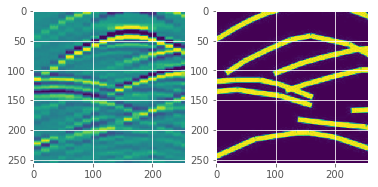

In [107]:
# split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)
# check if training data looks all right
plt.subplot(121)
plt.imshow(X_train[0].squeeze())
plt.subplot(122)
plt.imshow(y_train[0].squeeze())
plt.show()


## Build a U-Net Model

In [108]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

In [109]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [110]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activat

## Train the model

In [ ]:
#We use some callbacks to save the model while training, 
#lower the learning rate if the validation loss plateaues and perform early stopping.
callbacks = [
EarlyStopping(patience=10, verbose=1),
ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,validation_data=(X_valid, y_valid))

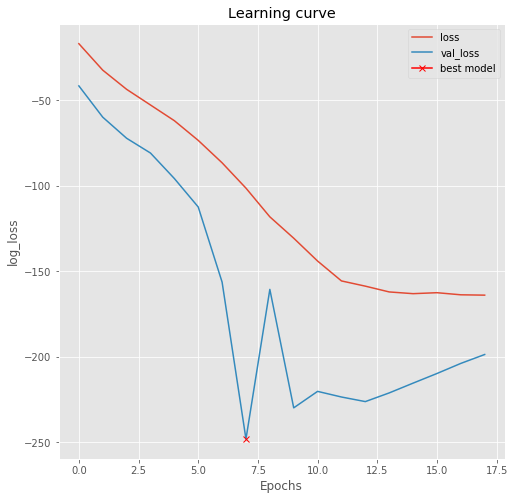

In [112]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [113]:
# Load best model
model.load_weights('model-tgs-salt.h5')
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

8/8 [==============================] - 6s 799ms/step


[-248.03689575195312, 0.22576522827148438]

In [114]:
# Predict on train, val set
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

8/8 [==============================] - 6s 799ms/step


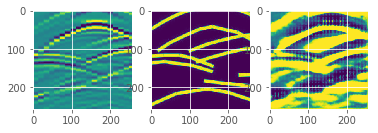

In [115]:
#check result
plt.subplot(131)
plt.imshow(X_train[0].squeeze())
plt.subplot(132)
plt.imshow(y_train[0].squeeze())
plt.subplot(133)
plt.imshow(preds_train[0].squeeze())
plt.show()

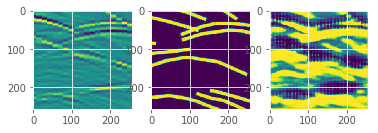

In [117]:
#check result
plt.subplot(131)
plt.imshow(X_valid[0].squeeze())
plt.subplot(132)
plt.imshow(y_valid[0].squeeze())
plt.subplot(133)
plt.imshow(preds_val[0].squeeze())
plt.show()

#### Reference
- https://www.depends-on-the-definition.com/unet-keras-segmenting-images/
- https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/
- https://library.seg.org/doi/full/10.1190/geo2018-0269.1